In [1]:
import pandas as pd
import numpy as np

import pymysql
from sqlalchemy import create_engine
from sqlalchemy import text
import pandas as pd
import getpass

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('clv_data.csv')

In [3]:
df['first_purchase'] = pd.to_datetime(df['first_purchase'])
df['latest_purchase'] = pd.to_datetime(df['latest_purchase'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cust_id           4314 non-null   int64         
 1   first_purchase    4314 non-null   datetime64[ns]
 2   latest_purchase   4314 non-null   datetime64[ns]
 3   frequency         4314 non-null   int64         
 4   total_spent       4314 non-null   float64       
 5   lifetime_in_days  4314 non-null   int64         
 6   CV                4314 non-null   float64       
 7   CLV               4314 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(3)
memory usage: 269.8 KB


In [4]:
df['first_month'] = df['first_purchase'].dt.month
df['latest_month'] = df['latest_purchase'].dt.month

df['first_year'] = df['first_purchase'].dt.year
df['latest_year'] = df['latest_purchase'].dt.year

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cust_id           4314 non-null   int64         
 1   first_purchase    4314 non-null   datetime64[ns]
 2   latest_purchase   4314 non-null   datetime64[ns]
 3   frequency         4314 non-null   int64         
 4   total_spent       4314 non-null   float64       
 5   lifetime_in_days  4314 non-null   int64         
 6   CV                4314 non-null   float64       
 7   CLV               4314 non-null   float64       
 8   first_month       4314 non-null   int32         
 9   latest_month      4314 non-null   int32         
 10  first_year        4314 non-null   int32         
 11  latest_year       4314 non-null   int32         
dtypes: datetime64[ns](2), float64(3), int32(4), int64(3)
memory usage: 337.2 KB


In [6]:
features = df.drop(columns=['CLV','CV','first_purchase','latest_purchase'])
target = df['CLV']

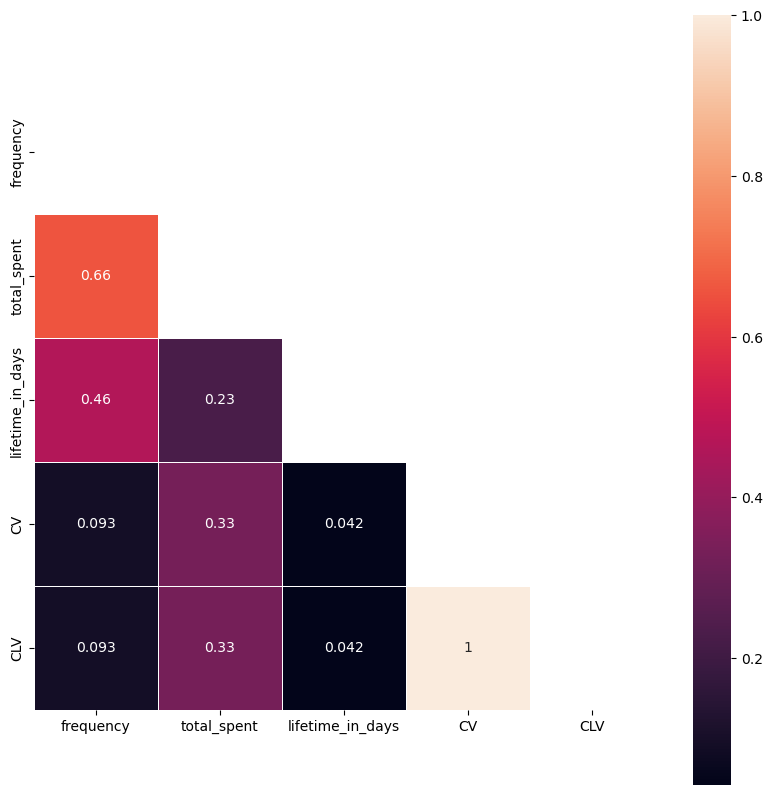

In [7]:
numerical = df[['frequency','total_spent','lifetime_in_days','CV','CLV']]

corr=np.abs(numerical.corr()) 

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths= .5, cbar_kws={"shrink": 1},annot = corr)

plt.show()

In [8]:
"""Compare MI scores across different features. Features with higher MI scores are considered more important or 
informative for predicting the target variable compared to those with lower scores."""
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(features, target)

mi_results = pd.DataFrame({
    'Feature': features.columns,
    'MI Score': mi_scores
})

mi_results


,Feature,MI Score
0,cust_id,0.027383
1,frequency,0.048996
2,total_spent,1.912275
3,lifetime_in_days,0.038361
4,first_month,0.000000
5,latest_month,0.017090
6,first_year,0.000000
7,latest_year,0.003382


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

scaler = MinMaxScaler()
scaler.fit(X_train)


X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

In [10]:
knn = KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train_scale, y_train)

knn.score(X_test_scale, y_test)

pred = knn.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", knn.score(X_test, y_test))

MAE 115800.15016305621
RMSE 196364.69252023156
R2 score 0.24615502712423154


C:\Users\NessaJay\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
C:\Users\NessaJay\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


In [11]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

pred2 = linreg.predict(X_test)

print("MAE", mean_absolute_error(pred2, y_test))
print("RMSE", mean_squared_error(pred2, y_test, squared=False))
print("R2 score", linreg.score(X_test, y_test))

MAE 109403.54051174215
RMSE 198876.9768835404
R2 score 0.22674229063020646


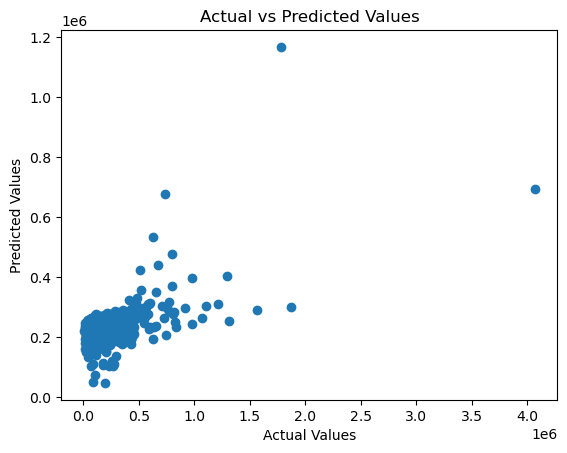

In [12]:
plt.scatter(y_test, pred2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()